# Inferential statistics II - Bootstrapping

## Introduction

In the previous frequentist mini-projects, you did frequentist calculations to perform inference from a sample of data. Such inference relies on theory largely developed from the 19th-Century onwards that is subject to certain assumptions or theoretical limits. These are fine if those assumptions hold for the particular case you're working on, and what you want to do has a known theoretical distribution (for example the mean of a sampling distribution that we looked at in the previous mini-project.)

In this mini-project, you'll use the same medical charge data you used in the frequentist inference mini-project, but this time you'll make inferences about the population using bootstrapping (ie. simulating repeated re-runs of an experiment.) If frequentism is about using assumptions and theoretical results to calculate what we expect to happen were an experiment to be run again and again and again, then bootstrapping is about using computing power to essentially re-run the sample draw again and again and again to see what actually happens.

## Prerequisites

While these exercises do not strictly depend on these concepts, we encourage you to complete the previous mini-projects before starting this one so that you can approach this assignment with a good understanding of frequentist concepts like:
* the _z_-statistic
* the _t_-statistic
* the difference and relationship between the two
* the Central Limit Theorem, its assumptions and consequences
* how to estimate the population mean and standard deviation from a sample
* the concept of a sampling distribution of a test statistic, particularly for the mean
* how to combine these concepts to calculate confidence intervals and p-values
* how those confidence intervals and p-values allow you to perform hypothesis (or A/B) tests

To complete mini-project, it's important that you first complete the bootstrap resources listed in this subunit, as they contain valuable information about how to calculate bootstrap replicates of summary statistics. Having an basic understanding of what confidence intervals and p-values are will also be helpful (we touch on them in this mini-project, but please speak to your mentor or conduct individual research if you'd like to learn more.) 

In [1]:
import pandas as pd
import numpy as np
from numpy.random import seed
import matplotlib.pyplot as plt

## Medical charge data set

In [2]:
med_charges = pd.read_csv('data/insurance2.csv')

In [3]:
med_charges.head()

,age,sex,bmi,children,smoker,region,charges,insuranceclaim
0,19,0,27.900,0,1,3,16884.92400,1
1,18,1,33.770,1,0,2,1725.55230,1
2,28,1,33.000,3,0,2,4449.46200,0
3,33,1,22.705,0,0,1,21984.47061,0
4,32,1,28.880,0,0,1,3866.85520,1


In the previous assignment, you used the frequentist approach to estimate the lower limit for the 95% confidence interval on the mean hospital charge. This approach relies on statistical theory that has been developed over the years and is also limited to statistics for which theoretical results on the sampling distribution exist. These results are remarkably useful and applicable much of the time and under a surprisingly wide range of conditions.

Having calculated the 95% lower confidence interval using frequentist theory in the previous exercise, you'll now use bootstrap inference to verify your calculations and check that you get consistent results without making the assumptions required before. After all, the distribution of charges really was very non-normal.

__Q:__ Use bootstrap sampling to estimate the same 95% confidence interval lower limit as before.

In [4]:
np.random.seed(47)
N_rep = 10000
# 1 First generate bootstrap samples by writing a custom function 
def bootstrap_replicate_1d(data, func):
    bs_sample = np.random.choice(data, len(data))
    return func(bs_sample)

In [5]:
# 2 Write a function to draw 10,000 bootstrap replicates from the samples
np.random.seed(47)
def draw_bs_reps(data, func, size=1):
    bs_replicates = np.empty(N_rep)
    for i in range(N_rep):
        bs_replicates[i] = bootstrap_replicate_1d(data,func)
    return bs_replicates

In [6]:
# 3 Call the function using the med_charges and mean function
np.random.seed(47)
bs_replicates = draw_bs_reps(med_charges['charges'], np.mean, N_rep)

In [23]:
# 4 Calculate the confidence interval using np.percentile() - used one-sided 
print(np.percentile(bs_replicates, [5.0,])) # [12724.4679217]

[12724.4679217]


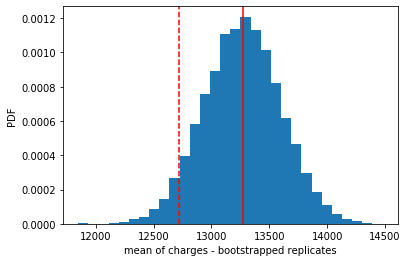

In [24]:
_ = plt.hist(bs_replicates, bins=30, density=True)
_ = plt.xlabel('mean of charges - bootstrapped replicates')   
_ = plt.ylabel('PDF')
_ = plt.axvline(np.mean(med_charges['charges']), color='r')
_ = plt.axvline(12724, color='r', linestyle='--')
#_ = plt.axvline(13918, color='r', linestyle='--')
plt.show()

If you performed 10000 replicates immediately after setting the random seed to 47, you should get the value 12724 here, which compares very well with the value 12725 obtained using the _t_-distribution confidence interval previously. It is a most pleasant result to see the predictions of classical frequentist theory match with results that are now possible through the number-crunching ability of computers.

Remember, in the previous mini-projects, we saw that there are two ways of performing a _t_-test from a sample, depending on whether we can assume the groups have equal variance or not. We can actually easily test this using the bootstrap approach!

__Q:__ Calculate the 95% confidence interval for the difference between the standard deviations of insurance and non-insurance claim charges (insured - non-insured). Calculate the differences over 10000 replicates. Plot the histogram of values and mark the locations of the percentiles. State the null and alternative hypothesis and comment on whether you would retain or reject the null hypothesis in this case and why.

__A:__The null hypothesis is that the non-insured and insured groups have equal variance.  The alternative hypothesis is that they have different variance.  Based on the results of the bootstrap analysis, we can reject the null hypothesis, because the confidence interval did not include 0.

In [10]:
# Calculate 95% confidence of diff between standard devs of insured - non-insured
#1 Parse the data into separate dataframes

with_insurance = med_charges[med_charges['insuranceclaim'] == 1] 
wo_insurance = med_charges[med_charges['insuranceclaim'] == 0] 

# 2 get the difference in standard deviation between insured - non-insured
diff = np.std(with_insurance['charges']) - np.std(wo_insurance['charges'])
print(np.std(with_insurance['charges'])) #14036
print(np.std(wo_insurance['charges'])) #6440.
print(np.std(with_insurance['charges']) - np.std(wo_insurance['charges'])) #7596

# 3 Calculate the confidence interval of diff between standard devs of insured - non-insured using np.percentile()
print(np.percentile(diff, [2.5,97.5])) # [7596.25640866 7596.25640866]

# 4 Alternatively, calculate manually
# 1 Calculate degrees of freedom for first dataframe 
# Sample size - 1 1338-1 = 1337
# 2 Lookup critical t value from table indicates t = 1.96
# 3 Divide the sample standard deviation by the square root of the sample size
temp = np.std(med_charges['charges'])/np.sqrt(1338) # 330.94
# 4 Multiply result by t value
temp2 = temp * 1.96 #648.64#  
#print(temp2)
# 5 To calculate 95% confidence interval of std of charges

print('sample min:  ',np.std(with_insurance['charges']) - np.std(wo_insurance['charges']) - temp2) #6947
print('sample max:  ',np.std(with_insurance['charges']) - np.std(wo_insurance['charges']) + temp2) #8244.90

14036.956250260411
6440.699841605233
7596.256408655178
[7596.25640866 7596.25640866]
sample min:   6947.606729399254
sample max:   8244.906087911102


In [11]:
# 3 Call the function to create replicates using the 2 separate populations and function diff_of_std
np.random.seed(47)
bs_replicates_with = draw_bs_reps(with_insurance['charges'], np.std, N_rep)
bs_replicates_wo = draw_bs_reps(wo_insurance['charges'], np.std, N_rep)

In [12]:
# 4 Calculate the confidence interval using np.percentile()
print(np.percentile(bs_replicates_with - bs_replicates_wo, [2.5,97.5])) # [6684.31447766 8500.74902263]

[6684.31447766 8500.74902263]


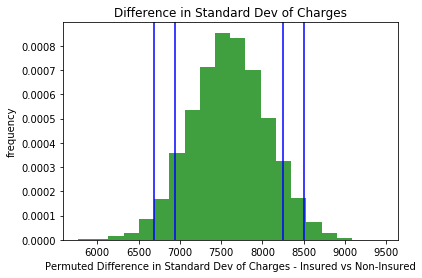

In [17]:
# Plot the results
#_ = plt.hist(bs_replicates_with,bins=20, color = 'r', density=True)
#_ = plt.hist(bs_replicates_wo,bins=20, color = 'g', density = True, alpha=.75)
_ = plt.hist(bs_replicates_with - bs_replicates_wo,bins=20, color = 'g', density = True, alpha=.75)
_ = plt.xlabel('Permuted Difference in Standard Dev of Charges - Insured vs Non-Insured')
_ = plt.ylabel('frequency')
_ = plt.title('Difference in Standard Dev of Charges')
_ = plt.axvline(6684, color='b')
_ = plt.axvline(8500, color='b')
_ = plt.axvline(6947, color='b')
_ = plt.axvline(8245, color='b')

## Confidence interval and p-value

The confidence interval above is often a useful quantity to estimate. If we wish to limit our expected probability of making a Type I error (where we wrongly reject the null hypothesis, and it is, instead, true) to $\alpha$, the associated confidence interval is our estimate of the interval within which we expect the true population value to be found $100\times(1 - \alpha)$% of the time we do this test. In the above we performed bootstrap replicates to estimate the interval and reject the null hypothesis if this interval did not contain zero. You will sometimes see such an interval reported in the output of statistical functions.

The partner of the confidence interval is the p-value. The p-value and the confidence interval are linked through our choice of $\alpha$. The p-value tells us how likely it is, under the null hypothesis, to get an outcome at least as extreme as what was observed. If this fails to reach the level of our _pre-specified_ $\alpha$, we decide the null hypothesis is sufficiently unlikely to be true and thus reject it. To calculate this p-value via the bootstrap, we have to put ourselves in a position where we are simulating the null hypothesis being true and then calculate the fraction of times we observe a result at least as extreme as that actually observed.

Remember how, previously, you used the _t_-test to calculate the p-value for the observed difference between the means of insured and non-insured medical cases. We're now going to repeat this, this time using the bootstrap approach.

__Q:__ Perform a bootstrapped hypothesis test at the 5% significance level ($\alpha = 0.05$) to calculate the p-value of the observed difference between insurance and non-insurance charges, state your null and alternative hypotheses and whether you retain or reject the null hypothesis for the given significance level.

__A:__The null hypothesis is that the non-insured and insured groups have no observed differences in charges using the mean to define difference.  The alternative hypothesis is that they have observed differences (means) in the charges.  We can reject the null hypothesis because the p-value was 0 indicating that we never see a permuted mean value that equals the empirical mean value.

In [18]:
# 1 Write a function to generate a permuation sample for 2 data sets
def permutation_sample(data_1, data_2):
    data = np.concatenate((data_1, data_2))
    permuted_data = np.random.permutation(data)
    perm_sample_1 = permuted_data[:len(data_1)]
    perm_sample_2 = permuted_data[len(data_1):]
    return perm_sample_1, perm_sample_2

In [19]:
# 2 Write a loop than generates permutation samples
def draw_perm_reps(data_1, data_2, func, size=1):
    """Generate multiple permutation replicates."""

    # Initialize array of replicates: perm_replicates
    perm_replicates = np.empty(size)

    for i in range(size):
        # Generate permutation sample
        perm_sample_1, perm_sample_2 = permutation_sample(data_1, data_2)

        # Compute the test statistic
        perm_replicates[i] = func(perm_sample_1, perm_sample_2)

    return perm_replicates

In [25]:
# 2 Write a custom function to calculate the difference in means between the 2 populations

def diff_of_means(data_1, data_2):
    """Difference in means of two arrays."""

    # The difference of means of data_1, data_2: diff
    diff = np.mean(data_1) - np.mean(data_2)

    return diff

In [26]:
#with_insurance.head(5)
# Convert dataframes to arrays
insured_array = with_insurance['charges'].to_numpy()
noninsured_array = wo_insurance['charges'].to_numpy()

In [27]:
# Compute difference of means between the 2 populations empirically: empirical_diff_means
empirical_diff_means = np.mean(with_insurance['charges']) - np.mean(wo_insurance['charges'])

# Draw 10,000 permutation replicates: perm_replicates
perm_replicates = draw_perm_reps(insured_array, noninsured_array,
                                 diff_of_means, size = 10000)

# Compute p-value: p
p = np.sum(perm_replicates == empirical_diff_means) / len(perm_replicates)
print(p)

0.0


__Q:__ To put the above result in perspective, plot the histogram of your bootstrapped differences along with lines marking the locations of the observed difference. (Why would we plot more than one line, given that we only have one observed difference?)

__A:__

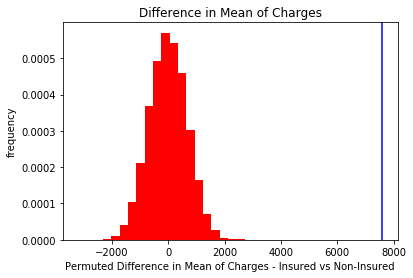

In [261]:
# Plot the results
_ = plt.hist(perm_replicates, bins=20, color = 'r', density=True)
_ = plt.xlabel('Permuted Difference in Mean of Charges - Insured vs Non-Insured')
_ = plt.ylabel('frequency')
_ = plt.title('Difference in Mean of Charges')
_ = plt.axvline(empirical_diff_means, color='b')

__Q:__ Compare your p-value above with that obtained using the _t_-test function in the previous assignment. Do you think you would want to try to perform enough bootstrap replicates to observe a random difference as large as that we did observe?

__A:__Considering the very small p values calculated before and the fact that in 10000 replicates we never see that value, it would likely take a very large population to observe the observed value difference. In fact the calculation of likelihood below indicates that we would never see that value in a normal distribution.

In [28]:
from scipy.stats import norm

likelihood = (1-norm.cdf(empirical_diff_means,loc=0,scale=1))*100
print(likelihood)

0.0


__Q:__ Consider the two variants of the _t_-test we performed in the previous assignment. Which one would you use now?

__A:The ttest_ind with equal_var = False

__Q:__ If, instead of being asked whether the means of two groups were different, you were working with an ad-recommender team who wanted to release a new recommendation algorithm, and you were looking at click-through rate both for the current algorithm (call it A) and from trials of their new algorithm (call it B), would you perform a two-sided test as above? What would be your null and alternative hypotheses and what would be the real-world consequence of rejecting the null hypothesis?

__A:__This would be an AB Test, which is a specific type of hypothesis testing used to compare two versions of a webpage against one another (or a single variable with variant A and B).  Yes a two-sided test comparing the rates of both A and B would be required to consider if B is a poorer alternative to A.  A one-sided test would consider only if B is a better alternative.  The null hypothesis is that there is no increase in rate between the current and new algorithm.  The consequence of rejecting the null hypothesis is that the new algorithm B would be given the green light to be used on the website.  

# Learning outcomes

You've previously applied frequentist methods to calculate confidence intervals, p-values, and perform hypothesis tests. Frequentist methods use theoretical results to calculate what we expect would happen if experiments were to be run again and again and again. Now you've seen how you can do the same things using the bootstrap approach, which does not rely on such theory, and attendant assumptions, but instead literally does run experiments again and again and again.

In these exercises, you have:
* calculated the same confidence interval lower limit as you did previously
* tested the assumption that the variances of the two groups (insured vs. non-insured) were equal - something a bit harder to do using the frequentist method because of the nature of the sampling distribution for variance
* calculated the p-value for the difference between the means of the two groups and compared with the result obtained using the previous frequentist approach

You are now well equipped to apply the bootstrap approach to a wide variety of problems. Just think about what conditions you wish to recreate in your simulated reruns.